# Using CNN  on a small MNIST data set

In this script we build a small CNN with 1 convolutional layer and 1 dense layer. Like in the experiments with the fully connected NN with MNIST that we performed last time, we use again a small data with only 2400 images in the training data set so that the NN can be trained on the CPU.

In [1]:
#!pip3 install sklearn ##for docker users 

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as imgplot
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

import time
import tensorflow as tf
tf.set_random_seed(1)

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, BatchNormalization
from keras.layers import Convolution2D, MaxPooling2D, Flatten
import keras
import sys
print ("Keras {} TF {} Python {}".format(keras.__version__, tf.__version__, sys.version_info))

Using TensorFlow backend.


Keras 2.2.4 TF 1.13.0-rc1 Python sys.version_info(major=3, minor=5, micro=2, releaselevel='final', serial=0)


In [3]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
X_train=x_train[0:2400]
Y_train=y_train[0:2400]

X_val=x_train[2400:3000]
Y_val=y_train[2400:3000]

X_test=x_test[0:1000]
Y_test=y_test[0:1000]

del x_train, y_train, x_test, y_test


In [4]:
X_train=np.reshape(X_train, (2400,28,28,1))
X_val=np.reshape(X_val, (600,28,28,1))
X_test=np.reshape(X_test, (1000,28,28,1))

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(2400, 28, 28, 1)
(600, 28, 28, 1)
(1000, 28, 28, 1)


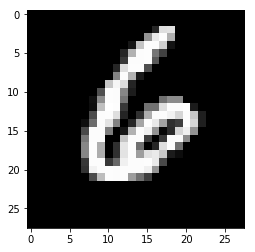

In [5]:
plt.imshow(X_train[13,:,:,0],cmap="gray")

In [6]:
pd.DataFrame(np.hstack((np.transpose(np.unique(Y_train,return_counts=True)),
                        np.transpose(np.unique(Y_val,return_counts=True)),
                        np.transpose(np.unique(Y_test,return_counts=True)))),
                        columns=["train_label","#train_examples",
                                 "val_label","#val_examples",
                                 "test_label","#test_examples"])

,train_label,#train_examples,val_label,#val_examples,test_label,#test_examples
0,0,225,0,60,0,85
1,1,265,1,74,1,126
2,2,238,2,61,2,116
3,3,231,3,64,3,107
4,4,263,4,62,4,110
5,5,219,5,55,5,87
6,6,243,6,63,6,87
7,7,265,7,64,7,99
8,8,213,8,48,8,89
9,9,238,9,49,9,94


In [7]:
def convertToOneHot(vector, num_classes=None):
    result = np.zeros((len(vector), num_classes), dtype='float32')
    result[np.arange(len(vector)), vector] = 1
    return result
print("class label")
print(Y_train[0:5])
print("class label in OneHot encodig")
print(convertToOneHot(Y_train[0:5], 10))

class label
[5 0 4 1 9]
class label in OneHot encodig
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [8]:
Y_train=convertToOneHot(Y_train,num_classes=10)
print(Y_train.shape)
Y_val=convertToOneHot(Y_val,num_classes=10)
print(Y_val.shape)

(2400, 10)
(600, 10)


## CNN without standardizing the data 


In [9]:
## here is the code to center and standardize the data
## lets try what happens without centering...
#X_mean = np.mean( X_train, axis = 0)
#X_std = np.std( X_train, axis = 0)

#X_train = (X_train - X_mean ) / (X_std + 0.0001)
#X_val = (X_val - X_mean ) / (X_std + 0.0001)

In [10]:
### First model with a convolutional layer
name = 'cnn1'
model = Sequential()

model.add(Convolution2D(32, (3, 3), padding='same', input_shape=(28, 28, 1)))
model.add(Activation('relu'))

model.add(Flatten())

model.add(Dense(10))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                250890    
_________________________________________________________________
activation_2 (Activation)    (None, 10)                0         
Total params: 251,210
Trainable params: 251,210
Non-trainable params: 0
_________________________________________________________________


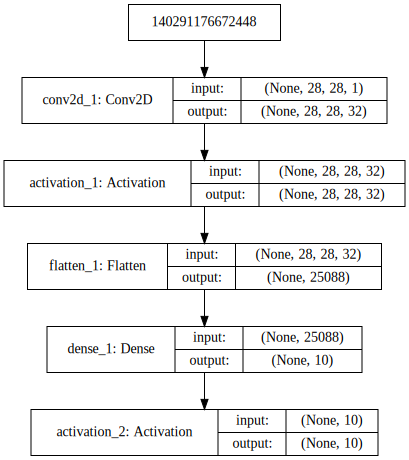

In [12]:
SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))


In [13]:
model.evaluate(X_train,Y_train)

2400/2400 [==============================] - 1s 224us/step


[12.489727846781413, 0.12416666666666666]

In [14]:
tensorboard = keras.callbacks.TensorBoard(
        log_dir='tensorboard/mnist/' + name + '/', 
        write_graph=True,
        histogram_freq=0)

In [15]:
history=model.fit(X_train, Y_train, 
                  batch_size=128, 
                  epochs=30,
                  verbose=2, 
                  validation_data=(X_val, Y_val),
                  callbacks=[tensorboard])

Instructions for updating:
Use tf.cast instead.
Train on 2400 samples, validate on 600 samples
Epoch 1/30
 - 1s - loss: 8.5466 - acc: 0.4504 - val_loss: 7.0565 - val_acc: 0.5583
Epoch 2/30
 - 1s - loss: 7.3640 - acc: 0.5379 - val_loss: 6.6675 - val_acc: 0.5817
Epoch 3/30
 - 1s - loss: 7.2562 - acc: 0.5433 - val_loss: 7.0498 - val_acc: 0.5550
Epoch 4/30
 - 1s - loss: 7.1763 - acc: 0.5517 - val_loss: 6.8523 - val_acc: 0.5667
Epoch 5/30
 - 1s - loss: 6.8591 - acc: 0.5708 - val_loss: 6.5374 - val_acc: 0.5900
Epoch 6/30
 - 1s - loss: 6.6724 - acc: 0.5821 - val_loss: 6.5952 - val_acc: 0.5867
Epoch 7/30
 - 1s - loss: 6.2067 - acc: 0.6087 - val_loss: 5.7970 - val_acc: 0.6367
Epoch 8/30
 - 1s - loss: 6.0027 - acc: 0.6225 - val_loss: 5.9280 - val_acc: 0.6250
Epoch 9/30
 - 1s - loss: 5.7196 - acc: 0.6392 - val_loss: 5.9969 - val_acc: 0.6267
Epoch 10/30
 - 1s - loss: 5.5893 - acc: 0.6496 - val_loss: 5.6219 - val_acc: 0.6467
Epoch 11/30
 - 1s - loss: 5.3454 - acc: 0.6646 - val_loss: 5.4964 - val_ac

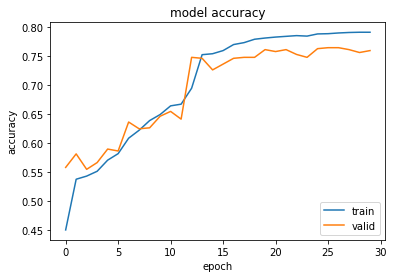

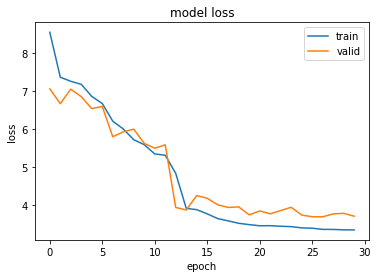

In [16]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

## Prediction on the test set


In [17]:
pred=model.predict(X_test)
print(confusion_matrix(Y_test,np.argmax(pred,axis=1)))
print("Acc = " ,np.sum(Y_test==np.argmax(pred,axis=1))/len(pred))

[[ 83   0   0   0   0   1   1   0   0   0]
 [  0 121   0   1   1   1   1   1   0   0]
 [  8   5   0  75   4   0   9  13   0   2]
 [  1   0   0  93   0   8   2   2   0   1]
 [  0   1   0   0 102   0   2   0   0   5]
 [  1   0   0   1   1  80   2   0   0   2]
 [  2   0   0   0   1   1  83   0   0   0]
 [  1   0   0   5   0   1   0  89   0   3]
 [  4  11   0  33   5  13   3  11   0   9]
 [  0   0   0   4   4   0   0   2   0  84]]
Acc =  0.735


In [18]:
del model

## CNN with standardizing the data 


In [19]:
## here is the code to center and standardize the data
X_mean = np.mean( X_train, axis = 0)
X_std = np.std( X_train, axis = 0)

X_train_norm = np.array((X_train - X_mean ) / (X_std + 0.0001),dtype="float32")
X_val_norm = np.array((X_val - X_mean ) / (X_std + 0.0001),dtype="float32")

In [20]:
### First model with a convolutional layer
name = 'cnn1_norm'
model = Sequential()

model.add(Convolution2D(32, (3, 3), padding='same', input_shape=(28, 28, 1)))
model.add(Activation('relu'))

model.add(Flatten())

model.add(Dense(10))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

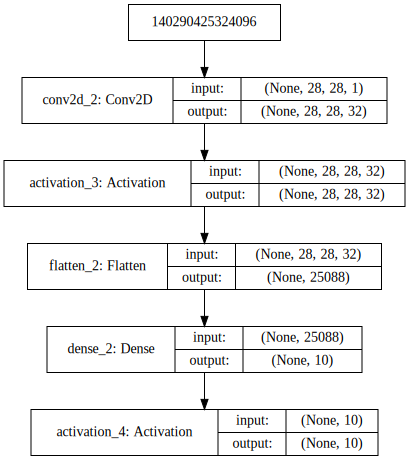

In [21]:
SVG(model_to_dot(model,show_shapes=True,).create(prog='dot', format='svg'))

In [22]:
model.evaluate(X_train_norm,Y_train)

2400/2400 [==============================] - 1s 299us/step


[2.3420405769348145, 0.06708333333333333]

In [23]:
tensorboard = keras.callbacks.TensorBoard(
        log_dir='tensorboard/mnist/' + name + '/', 
        write_graph=True,
        histogram_freq=0)

In [24]:
history=model.fit(X_train_norm, Y_train, 
                  batch_size=128, 
                  epochs=30,
                  verbose=2, 
                  validation_data=(X_val_norm, Y_val),
                  callbacks=[tensorboard])

Train on 2400 samples, validate on 600 samples
Epoch 1/30
 - 1s - loss: 0.9192 - acc: 0.7221 - val_loss: 0.5437 - val_acc: 0.8733
Epoch 2/30
 - 1s - loss: 0.3044 - acc: 0.9075 - val_loss: 0.4643 - val_acc: 0.8983
Epoch 3/30
 - 1s - loss: 0.1972 - acc: 0.9487 - val_loss: 0.4473 - val_acc: 0.8917
Epoch 4/30
 - 1s - loss: 0.1420 - acc: 0.9654 - val_loss: 0.4365 - val_acc: 0.9167
Epoch 5/30
 - 1s - loss: 0.1017 - acc: 0.9746 - val_loss: 0.4534 - val_acc: 0.9150
Epoch 6/30
 - 1s - loss: 0.0720 - acc: 0.9850 - val_loss: 0.4327 - val_acc: 0.9217
Epoch 7/30
 - 1s - loss: 0.0529 - acc: 0.9892 - val_loss: 0.4299 - val_acc: 0.9250
Epoch 8/30
 - 1s - loss: 0.0390 - acc: 0.9942 - val_loss: 0.4396 - val_acc: 0.9250
Epoch 9/30
 - 1s - loss: 0.0288 - acc: 0.9967 - val_loss: 0.4410 - val_acc: 0.9233
Epoch 10/30
 - 1s - loss: 0.0208 - acc: 0.9988 - val_loss: 0.4412 - val_acc: 0.9250
Epoch 11/30
 - 1s - loss: 0.0167 - acc: 0.9992 - val_loss: 0.4419 - val_acc: 0.9283
Epoch 12/30
 - 1s - loss: 0.0117 - acc

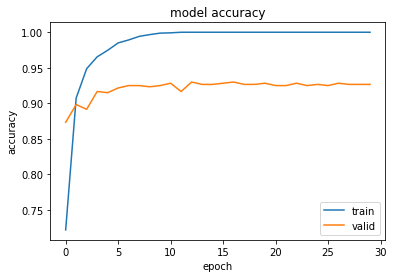

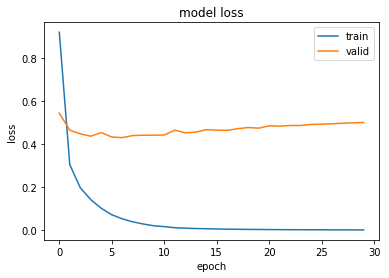

In [25]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

## Prediction on the normalized test set


In [26]:
X_test_norm = np.array((X_test - X_mean ) / (X_std + 0.0001),dtype="float32")
pred=model.predict(X_test_norm)
print(confusion_matrix(Y_test,np.argmax(pred,axis=1)))
print("Acc = " ,np.sum(Y_test==np.argmax(pred,axis=1))/len(pred))

[[ 83   0   1   0   0   0   1   0   0   0]
 [  0 124   0   1   0   0   1   0   0   0]
 [  0   0 103   2   0   0   0   4   4   3]
 [  1   0   0  91   2   6   1   2   2   2]
 [  1   1   1   0 102   0   1   0   0   4]
 [  1   0   1   1   1  77   1   1   2   2]
 [  2   0   1   0   1   4  79   0   0   0]
 [  0   3   2   2   0   1   0  89   0   2]
 [  2   0   3   2   4   0   0   2  76   0]
 [  0   0   1   0   1   0   0   3   0  89]]
Acc =  0.913


In [27]:
#!tensorboard --logdir=tensorboard/tensorboard/mnist/